In [3]:
from pymol import cmd
import rdkit
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
import prolif as plf
from prolif.plotting.network import LigNetwork
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from utilities.utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
import py3Dmol
import matplotlib.pyplot as plt
import subprocess
import multiprocessing
from concurrent import futures
from openbabel import pybel

In [2]:
!wget -O 1AZ8.pdb https://files.rcsb.org/download/1GYC.pdb

--2022-03-16 21:11:50--  https://files.rcsb.org/download/1GYC.pdb
正在解析主机 files.rcsb.org (files.rcsb.org)... 132.249.210.142
正在连接 files.rcsb.org (files.rcsb.org)|132.249.210.142|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：未指定 [application/octet-stream]
正在保存至: “1AZ8.pdb”

1AZ8.pdb                [      <=>           ] 419.48K   343KB/s  用时 1.2s      

2022-03-16 21:11:53 (343 KB/s) - “1AZ8.pdb” 已保存 [429543]



In [3]:
#处理蛋白质的方法
cmd.fetch(code='1GYC',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1GYC_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1GYC_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


In [6]:
#修复蛋白质
fix_protein(filename='1GYC_clean.pdb', addHs_pH=5, try_renumberResidues=True,output='1GYC_clean_H.pdb')

/home/hclee/miniconda3/envs/python37/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [20]:
# 处理要进行对接的分子
sdfFilePath = 'pei_ti.sdf' # The input file of structures to generate conformations from
ConfoutputFilePath = 'pei_ti_gouxiang.sdf' # Output file containing conformations for docking
inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
xxx=len(inputMols) # Check how many strucures
print(xxx)
print('以上是配体的分子数量')


3
以上是配体的分子数量


In [6]:
#检查配体分子名字
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

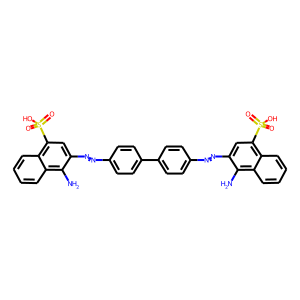

In [19]:
#m=Chem.MolFromMolFile('pei_ti_gouxinag.sdf',sanitize=False)
#Draw.MolToImage(m)

m = Chem.SDMolSupplier("pei_ti.sdf")
mols = [Chem.MolToSmiles(mol) for mol in m if mol]
Draw.MolToImage(m[0])

In [22]:
#为配体生成多种构象
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:00 |##############################|


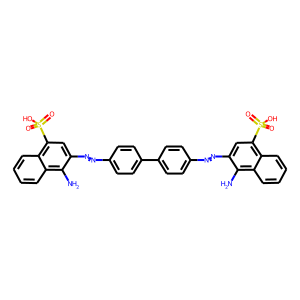

In [26]:
m = Chem.SDMolSupplier("pei_ti.sdf")
mols = [Chem.MolToSmiles(mol) for mol in m if mol]
Draw.MolToImage(m[0])

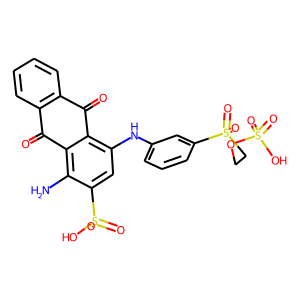

In [29]:
m2 = Chem.SDMolSupplier("pei_ti_gouxiang.sdf")
mols2 = [Chem.MolToSmiles(mol) for mol in m if mol]
Draw.MolToImage(m2[0])

In [4]:
ProteinForDocking = '1GYC_clean_H.pdb'
LigandFromProtein = '1GYC_lig.mol2'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [39]:
# 下载对接软件并安装
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
!chmod u+x smina.static
!./smina.static --help

--2022-03-17 17:46:36--  https://sourceforge.net/projects/smina/files/smina.static/download
正在解析主机 sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128
正在连接 sourceforge.net (sourceforge.net)|104.18.11.128|:443... 失败：连接超时。
正在连接 sourceforge.net (sourceforge.net)|104.18.10.128|:443... 失败：连接超时。
重试中。

--2022-03-17 17:50:59--  (尝试次数： 2)  https://sourceforge.net/projects/smina/files/smina.static/download
正在连接 sourceforge.net (sourceforge.net)|104.18.11.128|:443... 失败：连接超时。
正在连接 sourceforge.net (sourceforge.net)|104.18.10.128|:443... 失败：连接超时。
重试中。

--2022-03-17 17:55:22--  (尝试次数： 3)  https://sourceforge.net/projects/smina/files/smina.static/download
正在连接 sourceforge.net (sourceforge.net)|104.18.11.128|:443... 失败：连接超时。
正在连接 sourceforge.net (sourceforge.net)|104.18.10.128|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABiMwYOFa8os3G4dTF0-BV6binyn5hQfIzAzvuzi36bOxpenvCOTbm8CZkR6y7Wp1P2V4nLtOdJhN2zMBs5XCKkA7oHvQ%3D%

In [41]:
# 开始对接
!'./smina.static' --cpu 7 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

In [42]:
! chmod +x rf-score-vs
#给权限

In [19]:
TargetProtein = '1GYC_clean_H.pdb'
scoreResults = 'DockedRescored.csv'


In [49]:
! /home/hclee/PycharmProjects/pythonProject/rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [1]:
#打分最高
docked_df1 = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule', removeHs=False)
combinedResults = 'Alldata.sdf.gz'
scores_df = pd.read_csv(scoreResults)
results_df1 = pd.concat([docked_df1, scores_df], axis=1)
PandasTools.WriteSDF(results_df1, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df1.columns))
results_df1.sort_values(["RFScoreVS_v2"], axis=0, ascending=False, inplace=True) #or sort by scoring function
results_df1.head(5)


In [2]:
# 结合能最小
results_df.sort_values(["minimizedAffinity"], axis=0, ascending=False, inplace=True) #or sort by minimizedAffinity
results_df.head(5)

'1.3.4'

In [34]:
! gzip -d Alldata.sdf.gz
! gzip -d All_Docked.sdf.gz

gzip: Alldata.sdf.gz: No such file or directory


In [41]:
# 查看蛋白质与配体的化学键
# load protein
prot = mda.Universe("1GYC_clean_H.pdb")
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier('All_Docked.sdf'))
#lig_suppl = list(plf.mol2_supplier('1GYC_lig.mol2'))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/135 [00:00<?, ?it/s]

ligand               UNL1                                            \
protein          ASN172.A      ASN264.A      GLU142.A      GLU288.A   
interaction       HBDonor       HBDonor       HBDonor       HBDonor   
Frame                                                                 
0            (None, None)  (None, None)  (None, None)  (None, None)   
1            (None, None)  (None, None)  (None, None)  (None, None)   
2            (None, None)  (None, None)  (None, None)  (None, None)   
3            (None, None)  (None, None)       (17, 0)  (None, None)   
4            (None, None)  (None, None)  (None, None)  (None, None)   
5            (None, None)       (25, 0)  (None, None)  (None, None)   
6            (None, None)  (None, None)  (None, None)  (None, None)   
7            (None, None)  (None, None)  (None, None)  (None, None)   
8            (None, None)  (None, None)  (None, None)  (None, None)   
9                 (23, 0)  (None, None)  (None, None)  (None, None)   
10           (None, None)  (None, None)  (None, None)  (None, None)   
11           (None, None)  (None, None)  (None, None)  (None, None)   
12           (None, None)  (None, None)  (None, None)  (None, None)   
13           (None, None)       (25, 0)  (None, None)  (None, None)   
14                (23, 0)  (None, None)  (None, None)  (None, None)   
15           (None, None)       (25, 0)  (None, None)  (None, None)   
16           (None, None)  (None, None)  (None, None)  (None, None)   
17           (None, None)  (None, None)  (None, None)  (None, None)   
18           (None, None)  (None, None)  (None, None)  (None, None)   
19           (None, None)  (None, None)  (None, None)  (None, None)   
20           (None, None)  (None, None)  (None, None)  (None, None)   
21           (None, None)  (None, None)  (None, None)  (None, None)   
22           (None, None)  (None, None)  (None, None)  (None, None)   
23           (None, None)  (None, None)  (None, None)  (None, None)   
24           (None, None)  (None, None)  (None, None)  (None, None)   
25           (None, None)  (None, None)  (None, None)  (None, None)   
26           (None, None)  (None, None)  (None, None)  (None, None)   
27           (None, None)  (None, None)  (None, None)  (None, None)   
28           (None, None)  (None, None)  (None, None)  (None, None)   
29           (None, None)  (None, None)  (None, None)  (None, None)   
30           (None, None)  (None, None)  (None, None)  (None, None)   
31           (None, None)  (None, None)  (None, None)  (None, None)   
32           (None, None)  (None, None)  (None, None)  (None, None)   
33           (None, None)  (None, None)  (None, None)  (None, None)   
34           (None, None)  (None, None)  (None, None)  (None, None)   
35           (None, None)  (None, None)  (None, None)  (None, None)   
36           (None, None)  (None, None)  (None, None)  (None, None)   
37           (None, None)  (None, None)  (None, None)  (None, None)   
38           (None, None)  (None, None)  (None, None)  (None, None)   
39           (None, None)  (None, None)  (None, None)  (None, None)   
40           (None, None)  (None, None)  (None, None)  (None, None)   
41           (None, None)  (None, None)  (None, None)  (None, None)   
42           (None, None)  (None, None)  (None, None)  (None, None)   
43           (None, None)  (None, None)  (None, None)  (None, None)   
44           (None, None)  (None, None)  (None, None)  (None, None)   
45           (None, None)  (None, None)  (None, None)  (None, None)   
46           (None, None)  (None, None)  (None, None)  (None, None)   
47           (None, None)  (None, None)  (None, None)  (None, None)   
48           (None, None)  (None, None)  (None, None)  (None, None)   
49           (None, None)  (None, None)  (None, None)  (None, None)   
50           (None, None)  (None, None)  (None, None)  (None, None)   
51           (None, None)  (None, None)  (None, None)  (None, None)   
52           (None, None

In [47]:
net = LigNetwork.from_ifp(results_df, lig_suppl[112], kind="frame", frame=1, rotation=270)
net.display()

In [51]:
selectedPose = 'selectedpose.sdf'
selectedPoseH = 'selectedposeH.sdf'


In [3]:
PandasTools.WriteSDF(results_df.head(5), selectedPose, molColName="Molecule", idName="ID", properties=list(results_df.columns))
PandasTools.WriteSDF(results_df.head(5), selectedPose, molColName="Molecule", idName="ID", properties=list(results_df.columns))
selecteddocked_df = PandasTools.LoadSDF(selectedPose,molColName='Molecule', removeHs=False)
! /home/aistudio/external-libraries/bin/obabel  -isdf 'selectedpose.sdf'  -osdf   -h  -O 'selectedposeH.sdf'

In [18]:
import pandas as pd
dataframe = pd.DataFrame(results_df)

#将DataFrame存储为csv,index表示是否显示行名，default=True
dataframe.to_csv("test.csv",index=False,sep=',')


In [39]:
net = LigNetwork.from_ifp(results_df, lig_suppl[0], kind="frame", frame=1, rotation=270)
net.display()